In [11]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#ML methods
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

matplotlib.rcParams["font.size"] = 30
matplotlib.rcParams['figure.figsize'] = [12,12]

# Train/Test Samples

In [2]:
train_init = pd.read_csv('train.csv')
test_init = pd.read_csv('test.csv')

In [3]:
train_init.head() #show the first elements of the training sample

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
train_init.describe() #Showing some relevant parameters of feature distributions

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

# Handle Missing Values

In [5]:
train_init.isna().sum() #counting the missing value for each feature

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

If we guess that 'Cabin' is an irrelevant feature for the probability to survive, we have to deal with missing values in 'Embarked' and in 'Age'.
For 'Embarked' the 2 missing values can be replaced with the distribution mode

In [6]:
train_init['Embarked'].fillna(train_init['Embarked'].mode()[0], inplace=True)
test_init['Embarked'].fillna(train_init['Embarked'].mode()[0], inplace=True) #we use the mode of the training
                                                                             #sample, that is larger

For the 'Age', the choice of the mode might be too simplistic. A more robust parameter would be the median, that is more stable than the mean against outliers. However, it is reasonable to assume a correlation between 'Age' and 'Pclass', or between 'Age' and 'Fare', or between 'Age' and 'Sex'

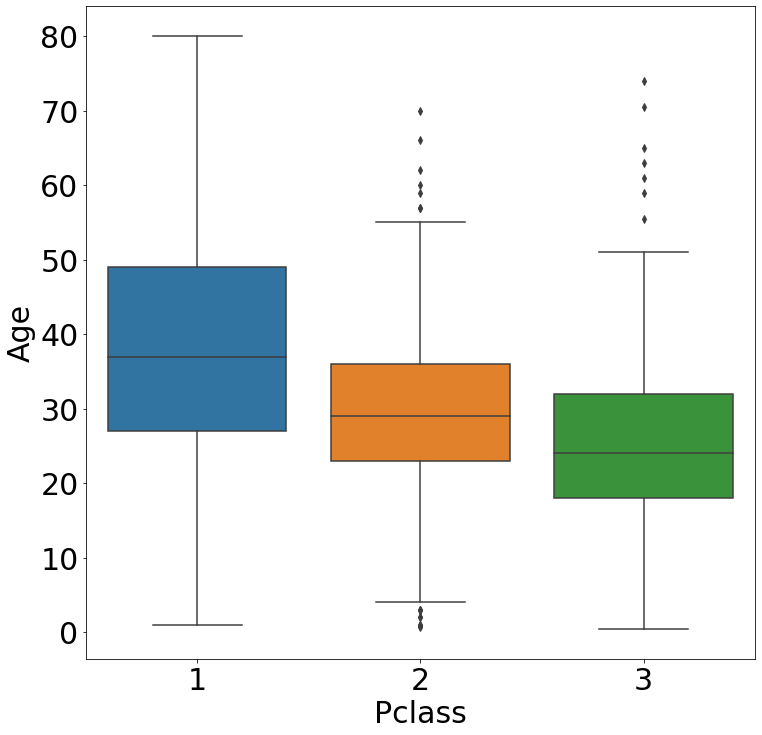

In [12]:
plt.subplots()

sns.boxplot(x="Pclass", y="Age", data=train_init)

plt.show()

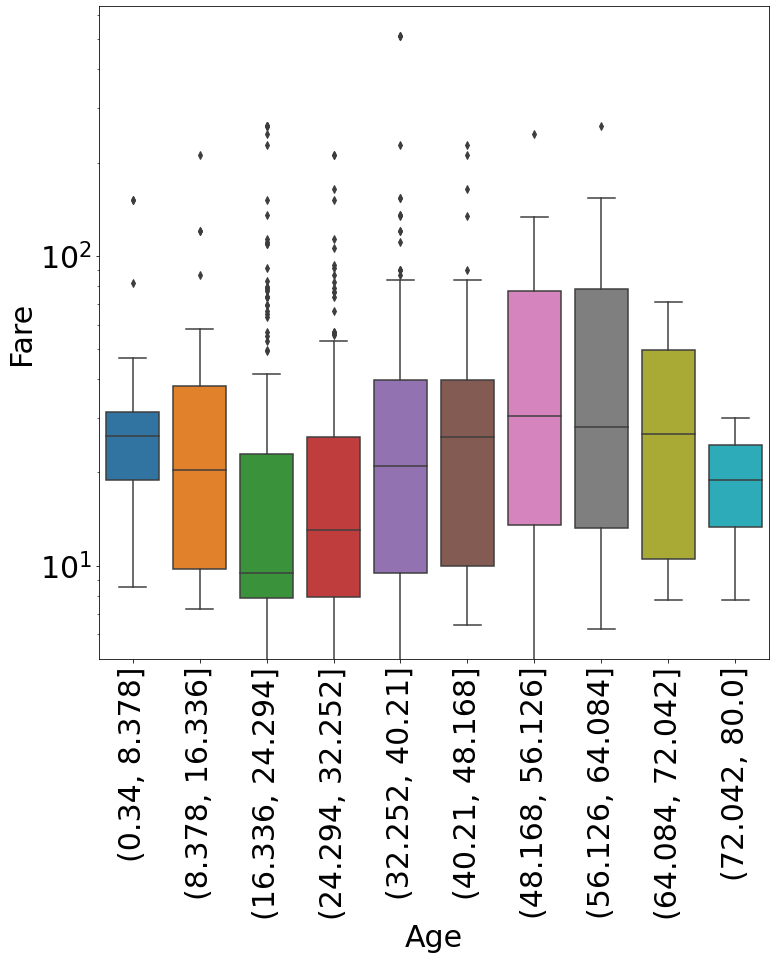

In [13]:
fig, ax = plt.subplots()


sns.boxplot(x=pd.cut(train_init['Age'], 10), y=train_init['Fare'])

plt.yscale('log')
plt.xticks(rotation = 90)
plt.show()

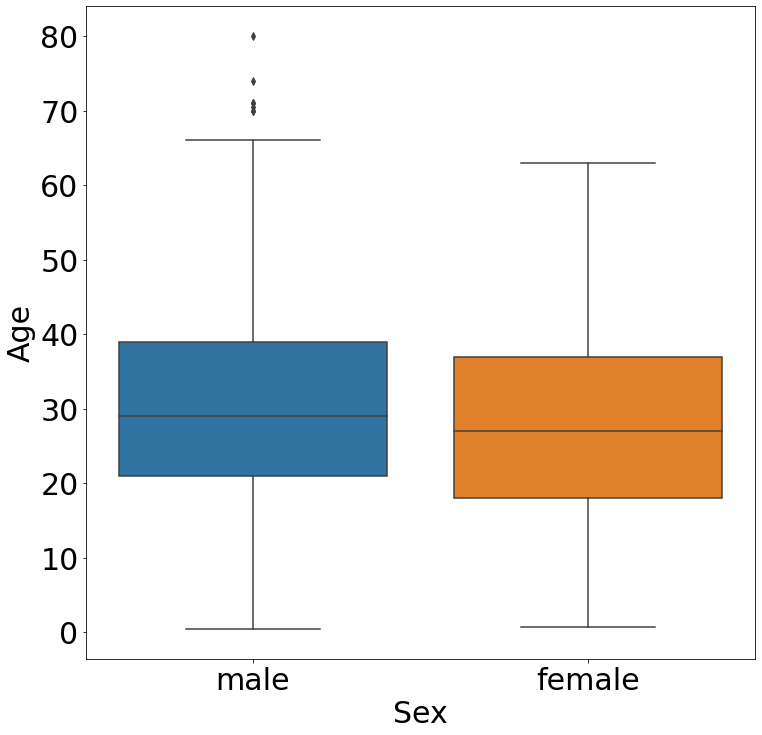

In [14]:
plt.subplots()

sns.boxplot(x="Sex", y="Age", data=train_init)

plt.show()

'Age' is indeed correlated with 'Pclass' and 'Fare', but not strongly with 'Sex'. The former correlation seems more systematic, hence we replace the missing age values with the median of the age in the corresponding Pclass feature

In [15]:
for cl in train_init['Pclass'].unique():
    print('Class: ', cl)
    class_median = train_init[train_init.Pclass == cl]['Age'].median()
    train_init.loc[ (train_init.Age.isnull()) & (train_init.Pclass == cl), 'Age' ] = class_median
    test_init.loc[ (test_init.Age.isnull()) & (test_init.Pclass == cl), 'Age' ] = class_median

Class:  3
Class:  1
Class:  2


In [16]:
train_init.isna().sum() #cross check that there are no missing values for 'Embarked' and 'Age'

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [17]:
test_init.isna().sum() #cross check that there are no missing values

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

The test sample has a missing value for 'Fare'. We replace it with the mean value of the corresponding class

In [18]:
cl = test_init[test_init['Fare'].isna()]['Pclass'].iloc[0]
class_mean = train_init[train_init.Pclass == cl]['Fare'].dropna().mean()
test_init.loc[ (test_init.Fare.isnull()) & (test_init.Pclass == cl), 'Fare' ] = class_mean

In [19]:
test_init.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

# Handle Categorical Features

Some features that might be useful for the analysis are non-numerical, i.e. categorical, and they must be converted into numbers. For this, we use the OneHotEncoder provided by sklearn

In [20]:
ohe = OneHotEncoder()
ct = make_column_transformer(
    (ohe, ['Sex', 'Embarked']), remainder='passthrough'
)

In [21]:
train_numeric = pd.DataFrame(ct.fit_transform(train_init.drop('Survived', axis=1)))
train_numeric['Survived'] = train_init['Survived']
train_numeric

0  1  2  3  4    5  6                                                  7  \
0    0  1  0  0  1    1  3                            Braund, Mr. Owen Harris   
1    1  0  1  0  0    2  1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2    1  0  0  0  1    3  3                             Heikkinen, Miss. Laina   
3    1  0  0  0  1    4  1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4    0  1  0  0  1    5  3                           Allen, Mr. William Henry   
..  .. .. .. .. ..  ... ..                                                ...   
886  0  1  0  0  1  887  2                              Montvila, Rev. Juozas   
887  1  0  0  0  1  888  1                       Graham, Miss. Margaret Edith   
888  1  0  0  0  1  889  3           Johnston, Miss. Catherine Helen "Carrie"   
889  0  1  1  0  0  890  1                              Behr, Mr. Karl Howell   
890  0  1  0  1  0  891  3                                Dooley, Mr. Patrick   

      8  9 10                11       12    13  Survived  
0    22  1  0         A/5 21171     7.25   NaN         0  
1    38  1  0          PC 17599  71.2833   C85         1  
2    26  0  0  STON/O2. 3101282    7.925   NaN         1  
3    35  1  0            113803     53.1  C123         1  
4    35  0  0            373450     8.05   NaN         0  
..   .. .. ..               ...      ...   ...       ...  
886  27  0  0            211536       13   NaN         0  
887  19  0  0            112053       30   B42         1  
888  24  1  2        W./C. 6607    23.45   NaN         0  
889  26  0  0            111369       30  C148         1  
890  32  0  0            370376     7.75   NaN         0  

[891 rows x 15 columns]

The encoder has created some dummy variables to represent the categorical features 'Sex' and 'Embarked'. Now we apply the same encoder to the test sample, and we restore the column names

In [22]:
test_numeric = pd.DataFrame(ct.transform(test_init))

In [23]:
train_numeric.rename({0:'Female',
                      1:'Male',
                      2:'C',
                      3:'Q',
                      4:'S',
                      5:'PassengerId',
                      6:'PClass',
                      7:'Name',
                      8:'Age',
                      9:'SibSp',
                      10:'Parch',
                      11:'Ticket',
                      12:'Fare',
                      13:'Cabin'}, axis=1, inplace=True)

test_numeric.rename({0:'Female',
                     1:'Male',
                     2:'C',
                     3:'Q',
                     4:'S',
                     5:'PassengerId',
                     6:'PClass',
                     7:'Name',
                     8:'Age',
                     9:'SibSp',
                     10:'Parch',
                     11:'Ticket',
                     12:'Fare',
                     13:'Cabin'}, axis=1, inplace=True)

In [24]:
train_numeric

Female Male  C  Q  S PassengerId PClass  \
0        0    1  0  0  1           1      3   
1        1    0  1  0  0           2      1   
2        1    0  0  0  1           3      3   
3        1    0  0  0  1           4      1   
4        0    1  0  0  1           5      3   
..     ...  ... .. .. ..         ...    ...   
886      0    1  0  0  1         887      2   
887      1    0  0  0  1         888      1   
888      1    0  0  0  1         889      3   
889      0    1  1  0  0         890      1   
890      0    1  0  1  0         891      3   

                                                  Name Age SibSp Parch  \
0                              Braund, Mr. Owen Harris  22     1     0   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  38     1     0   
2                               Heikkinen, Miss. Laina  26     0     0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  35     1     0   
4                             Allen, Mr. William Henry  35     0     0   
..                                                 ...  ..   ...   ...   
886                              Montvila, Rev. Juozas  27     0     0   
887                       Graham, Miss. Margaret Edith  19     0     0   
888           Johnston, Miss. Catherine Helen "Carrie"  24     1     2   
889                              Behr, Mr. Karl Howell  26     0     0   
890                                Dooley, Mr. Patrick  32     0     0   

               Ticket     Fare Cabin  Survived  
0           A/5 21171     7.25   NaN         0  
1            PC 17599  71.2833   C85         1  
2    STON/O2. 3101282    7.925   NaN         1  
3              113803     53.1  C123         1  
4              373450     8.05   NaN         0  
..                ...      ...   ...       ...  
886            211536       13   NaN         0  
887            112053       30   B42         1  
888        W./C. 6607    23.45   NaN         0  
889            111369       30  C148         1  
890            370376     7.75   NaN         0  

[891 rows x 15 columns]

# Select Features

In [25]:
train = train_numeric.drop(['PassengerId', 'Name', 'Parch', 'Ticket', 'Cabin'], axis=1)
test  = test_numeric.drop(['PassengerId', 'Name', 'Parch', 'Ticket', 'Cabin'], axis=1)

# Scale Features

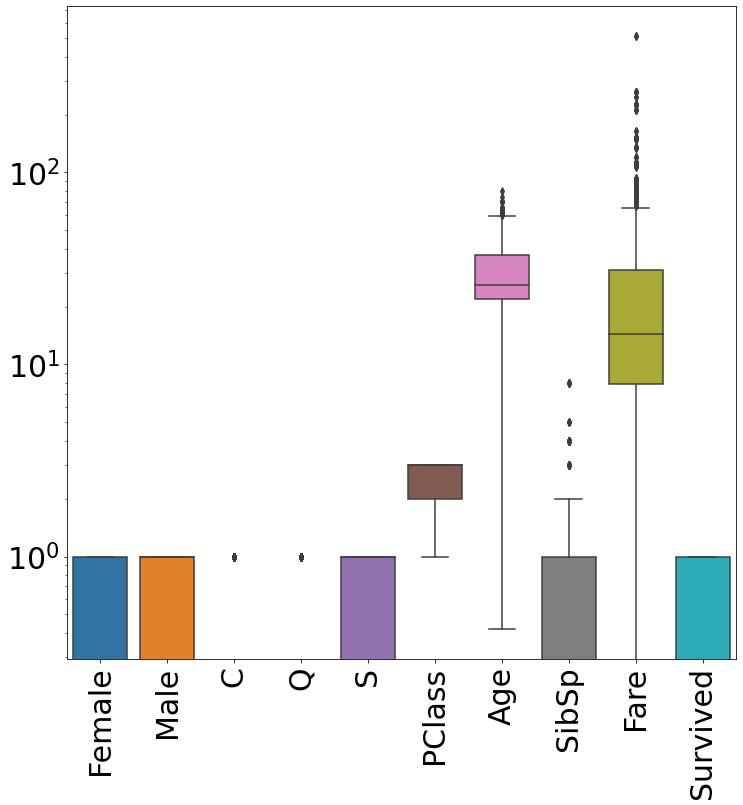

In [26]:
fig, ax = plt.subplots()

ax = sns.boxplot(data=train)
plt.yscale('log')
plt.xticks(rotation = 90)
plt.show()

Apart from 'Age' and 'Fare', features range more or less in the same order of magnitude. We want to scale the features to bring also 'Age' and 'Fare' in similar ranges. For this, we use the StandardScaler provided by sklearn

In [27]:
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train.drop(['Survived'], axis=1)), columns=list(train.drop(['Survived'], axis=1)))
test_scaled = pd.DataFrame(scaler.transform(test), columns=list(test))

In [28]:
train

Female Male  C  Q  S PClass Age SibSp     Fare  Survived
0        0    1  0  0  1      3  22     1     7.25         0
1        1    0  1  0  0      1  38     1  71.2833         1
2        1    0  0  0  1      3  26     0    7.925         1
3        1    0  0  0  1      1  35     1     53.1         1
4        0    1  0  0  1      3  35     0     8.05         0
..     ...  ... .. .. ..    ...  ..   ...      ...       ...
886      0    1  0  0  1      2  27     0       13         0
887      1    0  0  0  1      1  19     0       30         1
888      1    0  0  0  1      3  24     1    23.45         0
889      0    1  1  0  0      1  26     0       30         1
890      0    1  0  1  0      3  32     0     7.75         0

[891 rows x 10 columns]

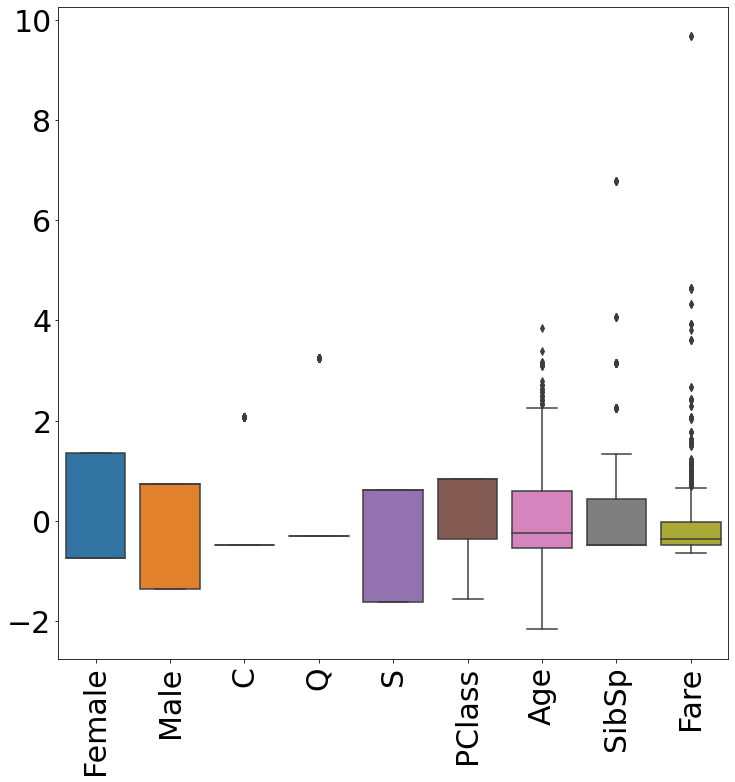

In [29]:
#check that features are scaled to the same interval - notice that physical interpretability is lost
fig, ax = plt.subplots()

ax = sns.boxplot(data=train_scaled)

plt.xticks(rotation = 90)
plt.show()

# ML algorithms

Now we separate the target from the predictors in the training sample, and we test several ML algorithms

In [30]:
x_train = train_scaled
y_train = train['Survived']
x_test  = test_scaled

ML_scores = pd.DataFrame(columns=['Model', 'Score', 'BestPar'])

### Logistic Regression

In [31]:
logreg = LogisticRegression()

logreg.fit(x_train, y_train)
logreg_score = logreg.score(x_train, y_train)
print('Logistic regression score: {:.1f}%'.format(logreg_score*100))

Logistic regression score: 80.6%


To check that our score is not biased by the particular training sample that we used, we use the cross validation method provided by sklearn

In [32]:
cv_scores = cross_val_score(logreg, x_train, y_train, cv=5)
print('Logistic regression score: ({:.1f} +- {:.1f})%'.format(cv_scores.mean()*100, cv_scores.std()*100/np.sqrt(len(cv_scores)-1)))

ML_scores = ML_scores.append({'Model': 'logreg', 'Score': logreg_score*100, 'BestPar': np.nan}, ignore_index=True)

Logistic regression score: (79.7 +- 0.7)%


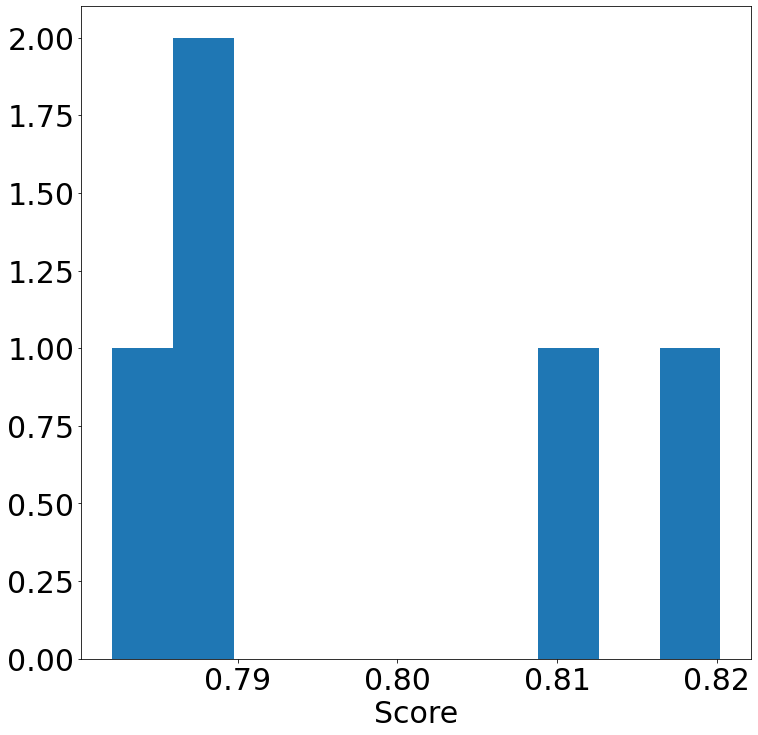

In [33]:
plt.subplots()

plt.hist(cv_scores)

plt.xlabel('Score')
plt.show()

For the logistic regression, we can also have a look at the correlation of the individual features:

In [34]:
coeff_df = pd.DataFrame(train_scaled.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

Feature  Correlation
0  Female     0.641102
2       C     0.077590
8    Fare     0.075187
3       Q     0.028574
4       S    -0.085953
7   SibSp    -0.390794
6     Age    -0.550035
1    Male    -0.641102
5  PClass    -0.979213

We observe that women have a positive correlation, and men a negative correlation, meaning that women are more likely to survive. Also, age is negatively correlated, showing that aged people are less likely to survive. Finally, we remark the strong anticorrelation with PClass, as we could expect

### KNeighborsClassifier

For the kNN algorithm, we test several parameter values up to 20 and we select the one with the best score

In [35]:
k_list, knn_score_list = [], []
for k in np.arange(1, 40):
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_scores = cross_val_score(knn, x_train, y_train, cv=5)
    k_list.append(k)
    knn_score_list.append(cv_scores.mean())
    
knn_cv_score = pd.DataFrame({
    'k': k_list,
    'knn_score': knn_score_list
})

best k: 20. Score: 81.93%


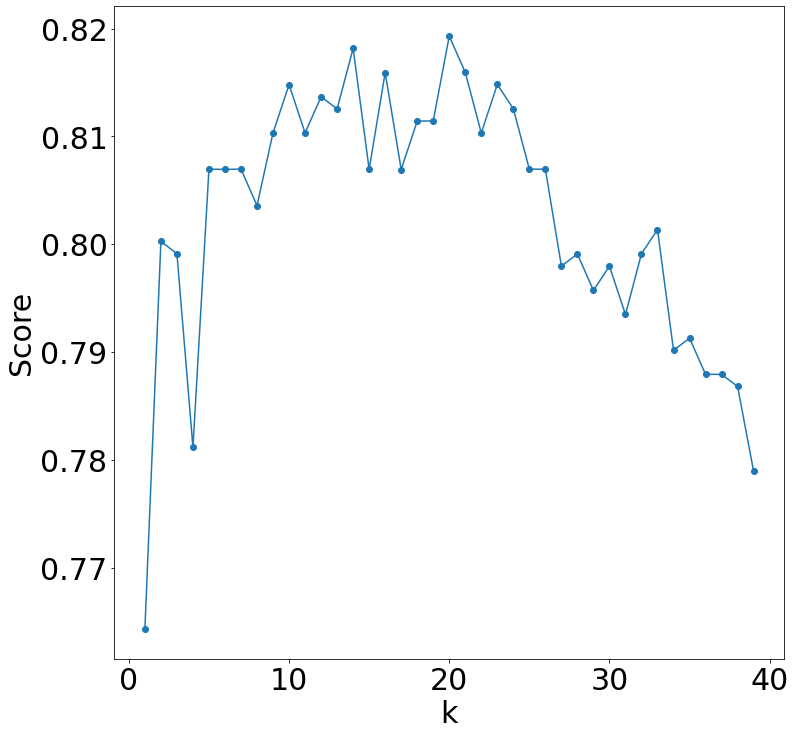

In [36]:
fig, ax = plt.subplots(figsize=(12,12))

plt.plot(knn_cv_score['k'], knn_cv_score['knn_score'], marker='o')

best_k = knn_cv_score['k'][np.argmax(knn_cv_score['knn_score'])]
print('best k: {}. Score: {:.2f}%'.format(best_k, 100*knn_cv_score['knn_score'].max()))

plt.xlabel('k')
plt.ylabel('Score')
plt.show()

The algorithm performs best with parameter 20

In [37]:
#cross validate result
knn.set_params(n_neighbors=best_k)

cv_scores = cross_val_score(knn, x_train, y_train, cv=5)
print('kNN score: ({:.1f} +- {:.1f})%'.format(cv_scores.mean()*100, cv_scores.std()*100/np.sqrt(len(cv_scores)-1)))

ML_scores = ML_scores.append({'Model': 'kNN', 'Score': cv_scores.mean()*100, 'BestPar': best_k}, ignore_index=True)

kNN score: (81.9 +- 0.7)%


### Naive Bayes

In [38]:
gaussian = GaussianNB()

gaussian.fit(x_train, y_train)
gauss_score = gaussian.score(x_train, y_train)
print('Naive Bayes score: {:.1f}%'.format(gauss_score*100))

ML_scores = ML_scores.append({'Model': 'NaiveBayes', 'Score': gauss_score*100, 'BestPar': np.nan}, ignore_index=True)

Naive Bayes score: 79.0%


### Decision Tree

In [39]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
tree_score = decision_tree.score(x_train, y_train)
print('Decision tree score: {:.1f}%'.format(tree_score*100))

Decision tree score: 98.0%


The score seems strangely high. We perform cross validation to obtain a more reliable score

In [40]:
#cross validate result
cv_scores = cross_val_score(decision_tree, x_train, y_train, cv=5)

print('Decision tree score: ({:.1f} +- {:.1f})%'.format(cv_scores.mean()*100, cv_scores.std()*100/np.sqrt(len(cv_scores)-1)))

ML_scores = ML_scores.append({'Model': 'Decision tree', 'Score': cv_scores.mean()*100, 'BestPar': np.nan}, ignore_index=True)

Decision tree score: (78.8 +- 1.3)%


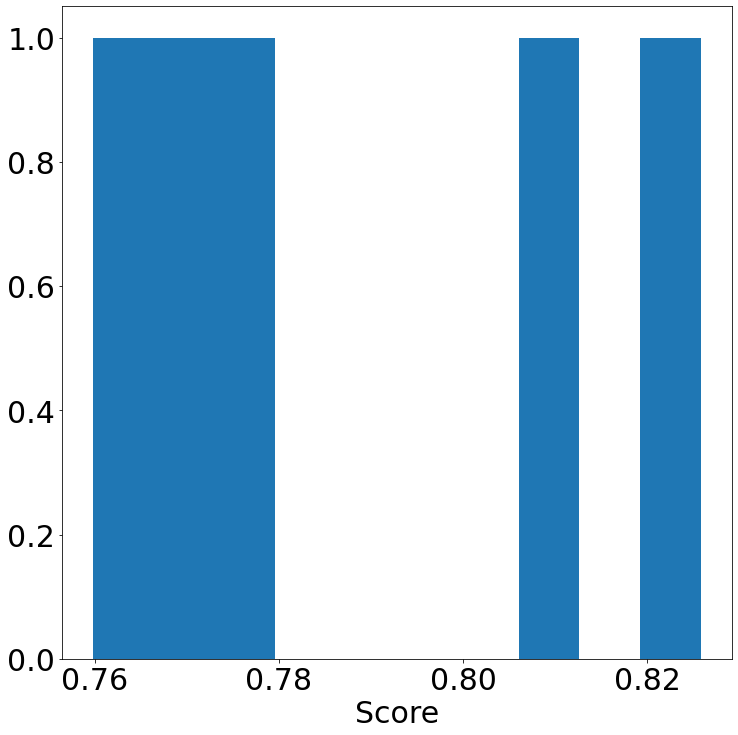

In [41]:
plt.subplots()

plt.hist(cv_scores)

plt.xlabel('Score')
plt.show()

### Random Forest

In [42]:
nEst_list, RF_score_list = [], []
for nEst in np.arange(5, 100, 5):
    random_forest = RandomForestClassifier(n_estimators=nEst)
    RF_scores = cross_val_score(random_forest, x_train, y_train, cv=5)
    
    nEst_list.append(nEst)
    RF_score_list.append(RF_scores.mean())

RF_cv_score = pd.DataFrame({
    'nEst': nEst_list,
    'RF_score': RF_score_list
})

best nEst: 35. Score: 81.82%


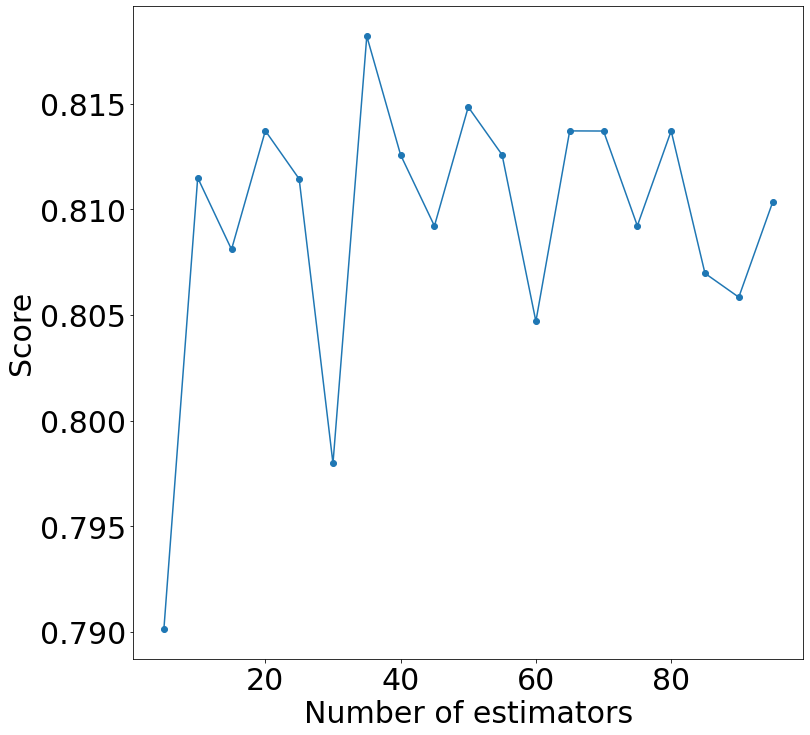

In [43]:
fig, ax = plt.subplots(figsize=(12,12))

plt.plot(RF_cv_score['nEst'], RF_cv_score['RF_score'], marker='o')
best_nEst = RF_cv_score['nEst'][np.argmax(RF_cv_score['RF_score'])]
print('best nEst: {}. Score: {:.2f}%'.format(best_nEst, 100*RF_cv_score['RF_score'].max()))

plt.xlabel('Number of estimators')
plt.ylabel('Score')
plt.show()
ML_scores = ML_scores.append({'Model': 'RF', 'Score': RF_cv_score['RF_score'].max()*100, 'BestPar': best_nEst}, ignore_index=True)

# Summary and Prediction

In [44]:
ML_scores.sort_values(by='Score', ascending=False)

Model      Score  BestPar
1            kNN  81.929571     20.0
4             RF  81.819095     35.0
0         logreg  80.583614      NaN
2     NaiveBayes  79.012346      NaN
3  Decision tree  78.791036      NaN

Similar scores are obtained by Random Forest and kNN. We use kNN for our prediction

In [45]:
print('best k: ', best_k)
knn.set_params(n_neighbors = best_k)

knn.fit(x_train, y_train)
y_hat = knn.predict(x_test)

best k:  20


In [46]:
y_hat

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,